In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import string
%matplotlib inline

# sklearn specific imports
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from gensim.models import Word2Vec


### Load and Clean Data

In this section we upload and clean our data.

Uploaded the data. The data consists of ``products.csv`` with the product reviews.

In [ ]:
products = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/products.csv')
products = products.iloc[0:5000] # For the sake of computation, we will only look at 5000 reviews
print('Number of reviews:', len(products))
print('Dataframe Columns', products.columns)
# Let's look at a specific product
print('Name:', products.iloc[0]['name'])
print('Review:', products.iloc[0]['review'])
print('Rating:', products.iloc[0]['rating'])

# REMOVE products with review equal to 3
products = products[products['rating'] != 3]

def remove_punctuation(text):
    if type(text) != str:
        return ''
    return text.translate(str.maketrans('', '', string.punctuation))

products['review'] = products['review'].apply(remove_punctuation)
len(products)
products['sentiment'] = products['rating'].apply(lambda rating : +1 if rating > 3 else -1)
products.head()

Number of reviews: 5000
Dataframe Columns Index(['name', 'review', 'rating'], dtype='object')
Name: Stop Pacifier Sucking without tears with Thumbuddy To Love's Binky Fairy Puppet and Adorable Book
Review: All of my kids have cried non-stop when I tried to ween them off their pacifier, until I found Thumbuddy To Love's Binky Fairy Puppet.  It is an easy way to work with your kids to allow them to understand where their pacifier is going and help them part from it.This is a must buy book, and a great gift for expecting parents!!  You will save them soo many headaches.Thanks for this book!  You all rock!!
Rating: 5


,name,review,rating,sentiment
0,Stop Pacifier Sucking without tears with Thumb...,All of my kids have cried nonstop when I tried...,5,1
1,Nature's Lullabies Second Year Sticker Calendar,We wanted to get something to keep track of ou...,5,1
2,Nature's Lullabies Second Year Sticker Calendar,I only purchased a secondyear calendar for my ...,2,-1
3,Nature's Lullabies Second Year Sticker Calendar,My daughter had her 1st baby over a year ago S...,5,1
4,"Lamaze Peekaboo, I Love You",One of babys first and favorite books and it i...,4,1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Performed a train/test split.


In [ ]:
products_train, products_test = train_test_split(products, test_size = 0.2, random_state = 1)

### A majority classifier

A reasonable first classifier is to figure out what the majority sentiment is in the training set and use that as a predictor on the test set.


In [ ]:
# find the majority class (positive or negative) in the training set

products_train['sentiment'].value_counts()
# 2309 negative reviews and 1691 positive reviews
train_sentiment = products_train['sentiment'].mean()
products_test.head()

# Checking accuracy
y_true = products_test['sentiment']
y_pred = -1 * np.ones(shape=(len(products_test),1)) #Predicted sentiment is all negative (-1)

accuracy_score(y_true, y_pred)

#Accuracy is 58.6% when we blindly predict that every review in the test set is of negative sentiment

0.586

### Featurizing sentences

Now we will use a ``CountVectorizer`` to turn our reviews, which our sentences, into features.

The count vectorizer takes each sentence, removes punctuation and does a bit of other preprocessing. It then converts the sentence into a list of tokens (words). Then, for each word that appears in the sentence it counts the number of times a given word appears and encodes it in a vector.

The CountVectorizer collects a list of all words that appear, ['It', 'is', 'and', 'cat', 'ball']. Then for each sentence it returns a list of how many times each word appears. Thus s1:[1, 1, 0, 1, 0], s2:[1, 1, 1, 1, 1], s3:[1, 1, 2, 2, 1]

These vectors are going to form our features

In [ ]:
count_vectorizer = CountVectorizer(lowercase=True, token_pattern=u"(?u)\\b\\w+\\b", stop_words='english')
X_train = count_vectorizer.fit_transform(products_train['review'])
y_train = products_train['sentiment']

words = count_vectorizer.get_feature_names_out()
print(words)

# The two numbers printed out should match
print('vocab in count_vectorizer:', len(count_vectorizer.get_feature_names_out()), 'dimension of X', X_train.shape[1])

# We "trained" our count-vectorizer on the train set, now we run it on the test-set
X_test = count_vectorizer.transform(products_test['review'])
y_test = products_test['sentiment']

# Finally we build a tokenizer
tokenizer = count_vectorizer.build_analyzer() # We will use this later to tokenize our sentences

['0' '001' '01' ... 'zoo' 'zookeepers' 'zoos']
vocab in count_vectorizer: 14802 dimension of X 14802


The CountVectorizer is fitted onto the training dataset only. The frequencies of the words are learned here, and then they are applied to the test set to estimate the performance of the algorithm.

### Build a Logistic Regression Classifier on Bag of Words Features

Now we build a logistic classifier on our resulting feature representation. The logistic regression classifier is effectively going to learn a feature per word in our list of words on the training set from above.


In [ ]:
#Train a logisitic regression model on the training set
sentiment_model = LogisticRegression(C=1).fit(X_train,y_train)

Now we can use this model to make predictions. Use the model to find the predicted probabilities on a small subset of 3 points

In [ ]:
sample_test_data = X_test[1:11]
probs = sentiment_model.predict_proba(sample_test_data)
print(probs)

[[9.87183651e-01 1.28163488e-02]
 [9.65456091e-01 3.45439088e-02]
 [1.97189486e-01 8.02810514e-01]
 [6.19836617e-04 9.99380163e-01]
 [6.88248772e-01 3.11751228e-01]
 [9.84068040e-01 1.59319596e-02]
 [9.44270372e-01 5.57296280e-02]
 [9.84759031e-01 1.52409692e-02]
 [1.59305465e-01 8.40694535e-01]
 [1.33366270e-03 9.98666337e-01]]


In [ ]:
print(list(zip(words[1500:1520],sentiment_model.coef_[0,1500:1520])))

[('bathsi', -0.01879155131918723), ('baththe', 0.08114320284308224), ('bathtime', 0.09278254596438429), ('bathtimeand', -9.306374813260803e-05), ('bathtub', 0.4713882990122745), ('bathtubs', 0.20648651945610857), ('bathtubthe', -0.012675606301970671), ('bathtubthis', 0.05923402067021712), ('batiste', -0.04019695452466787), ('batted', 0.04047100300667036), ('battered', 0.015435312115969279), ('batteries', -0.7777566448284221), ('batteries3', -0.0007042062391138165), ('batteriesnow', -0.00835076210828282), ('battery', -0.672336811637484), ('batterytake', -9.641504853212602e-06), ('batting', -0.012246095625858069), ('battle', -0.01637143240296546), ('bauer', -0.3547659435743857), ('baught', -0.05601071173644782)]


Now we extract the weights from the logistic model and print the words with the five largest and five smallest coefficients.

In [ ]:
# get 5 largest indices
best_5 = np.argsort(probs, axis=1)[:,-5:]
words = count_vectorizer.get_feature_names_out()
print(words)
for i in range(5):
    print(words[best_5[i]], end=", ")


['0' '001' '01' ... 'zoo' 'zookeepers' 'zoos']
['001' '0'], ['001' '0'], ['0' '001'], ['0' '001'], ['001' '0'], 

### Assessing the Bag of words model

We will now use the model to build a confusion matrix. A common tool that helps assess classification models is the confusion matrix.

We've created a function that will plot a confusion matrix for you given a set of inputs which are the values that should appear within each cell.

In [ ]:
def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data, annot=True, cmap='YlGnBu',
                xticklabels=['Actual Pos.', 'Actual Neg.'],
                yticklabels=['Pred. Pos.', 'Pred. Neg.'])

[[497  89]
 [ 92 322]]


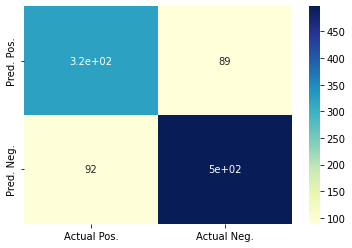

In [ ]:
tp = 0
fp = 0
tn = 0
fn = 0
i= 0
pred = sentiment_model.predict(X_test)
# TODO: Compute the number of true positives, false positives, true negatives, false negatives
# on the test set.
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, pred)
print(conf_mat)
tp = conf_mat[1, 1]
fp = conf_mat[0, 1]
tn = conf_mat[0, 0]
fn = conf_mat[1, 0]
plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)


Now that we have succesfully trained a model, let's compare the accuracy of the `sentiment_model` to that of the baseline majority class classifier.

In [ ]:
# use sklearns accuracy_score function to compute the accuracy of the model on the test set
s1 = accuracy_score(products_test['sentiment'], products_test['sentiment'])
s2 = accuracy_score(y_test, pred)
print(s1)
print(s2)

1.0
0.819


### Build a Classifier using word2vec features

In [ ]:
import gensim.downloader as api
model = api.load("glove-twitter-100")


Now we will take each sentence and build a feature vector base on our Word2Vec model.

For each sentence in the dataset, we will first split it into words (tokenize it) using the ``count_vectorizer.build_tokenizer()`` function. Then for each word, we will use word2vec to get a word embedding, and we will average these over the words in a review

In [ ]:
# word2vec model
def get_average_word2vec(sentence, tokenizer, word2vec):
    tokens = tokenizer(sentence)
    v  =0
    total = 0
    for word in tokens:
        if word in word2vec.vocab:
            total += 1
            vec = word2vec.word_vec(word) # TODO: get the word_vec from the word2vec model as in Problem 4
            v += vec/np.linalg.norm(vec)
    if total>0:
        return v/total
    return np.zeros(300)

# The tokenizer we use was trained above
X_train = np.array([get_average_word2vec(sentence, tokenizer, model) for sentence in products_train['review']])
X_test = np.array([get_average_word2vec(sentence, tokenizer, model) for sentence in products_test['review']])

# Train a logistic model
sentiment_model_w2v = LogisticRegression()
model = sentiment_model_w2v.fit(X_train, y_train)

Now we can train the model and assess it's accuracy on the test set.

In [ ]:
# use sklearns accuracy_score function to compute the accuracy of the model on the test set
pred1 = sentiment_model_w2v.predict(X_test)
model_acc = accuracy_score(y_test, pred1)
print(model_acc)

0.757




**The Bag of Words model performs better.**


## Hyperparameter tuning

Hyperparameter tuning to pick the best possible value of lambda.



In [ ]:

from sklearn.model_selection import GridSearchCV
hyper_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
sentiment_model_w2v = LogisticRegression()
grid_search = GridSearchCV(sentiment_model_w2v, hyper_grid, cv=5)
grid_search.fit(X_train, y_train)
print("hyperparameters:", grid_search.best_params_)
print("accuracy:", grid_search.best_score_)

# Ans - accuracy 78.7%

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _che

hyperparameters: {'C': 10}
accuracy: 0.787


/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## Bonus 2

Remark: There are many ways of taking sentences and featurizing them. Finding new effective ways of doing this is a hot topic of research and in the last few years after word2vec was introduced, several new models such as Glove, Bert, Elmo have been proposed (and buiilt at UW!). These models use Recurrent neural networks, and transformer architectures.

Use one of these models - or build your own based on an RNN and try to beat the logistic classifier above.
